In [11]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [18]:
class KNN:

    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        """
        Store the training data.
        X: training features, y: training labels (Exited or not)
        """
        self.X_train = np.array(X, dtype=np.float32)  # Ensure X is a NumPy array
        self.y_train = np.array(y, dtype=np.float32)  # Ensure y is a NumPy array


    def predict(self, X):
        """
        Predict the probability that customers will exit the bank for the given test set X.
        Output is a probability between 0 and 1, representing the likelihood of exiting.
        """
        X = np.array(X, dtype=np.float32)  # Ensure X is a NumPy array

        probabilities = []
        for x in X:  # Process each test point individually
            # Compute distances to all training points
            if self.distance_metric == 'euclidean':
                distances = np.linalg.norm(self.X_train - x, axis=1)
            elif self.distance_metric == 'manhattan':
                distances = np.sum(np.abs(self.X_train - x), axis=1)
            else:
                raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

            # Find k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]

            # Get the labels of the k nearest neighbors
            k_nearest_labels = [self.y_train[i] for i in k_indices]

            # Calculate the probability as the proportion of 1's (exited) among the k neighbors
            prob = np.mean(k_nearest_labels)
            probabilities.append(prob)

        return np.array(probabilities)



def predict_in_batches(knn, X, batch_size=1000):
  """
  Predict in batches to avoid memory overload.
  knn: trained KNN model
  X: test features
  batch_size: number of instances to predict at once
  """
  n_samples = X.shape[0]
  predictions = []

  # Process in batches
  for i in range(0, n_samples, batch_size):
      X_batch = X[i:i + batch_size]
      batch_predictions = knn.predict(X_batch)
      predictions.extend(batch_predictions)

  return np.array(predictions)








In [13]:
def preprocess_data(train_path, test_path):
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)


    #drop the less important columns
    train_data = train_data.drop(columns=['id', 'CustomerId', 'Surname', 'Geography', 'Gender', 'HasCrCard'])
    test_data = test_data.drop(columns=['id', 'CustomerId', 'Surname', 'Geography', 'Gender', 'HasCrCard'])

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
    test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

    #Fill in empty columns
    train_data.fillna(train_data.mean(), inplace=True)
    test_data.fillna(test_data.mean(), inplace=True)

    # Separate features and labels for training
    X_train = train_data.drop(columns=['Exited'])
    y_train = train_data['Exited']

    X_train = X_train.astype(np.float32)
    X_test = test_data.astype(np.float32)

    return X_train, y_train, X_test

Correlation with 'Exited':
 Exited             1.000000
Age                0.450622
Balance            0.164444
EstimatedSalary    0.025293
Tenure            -0.016268
CreditScore       -0.038903
IsActiveMember    -0.205586
NumOfProducts     -0.289624
Name: Exited, dtype: float64


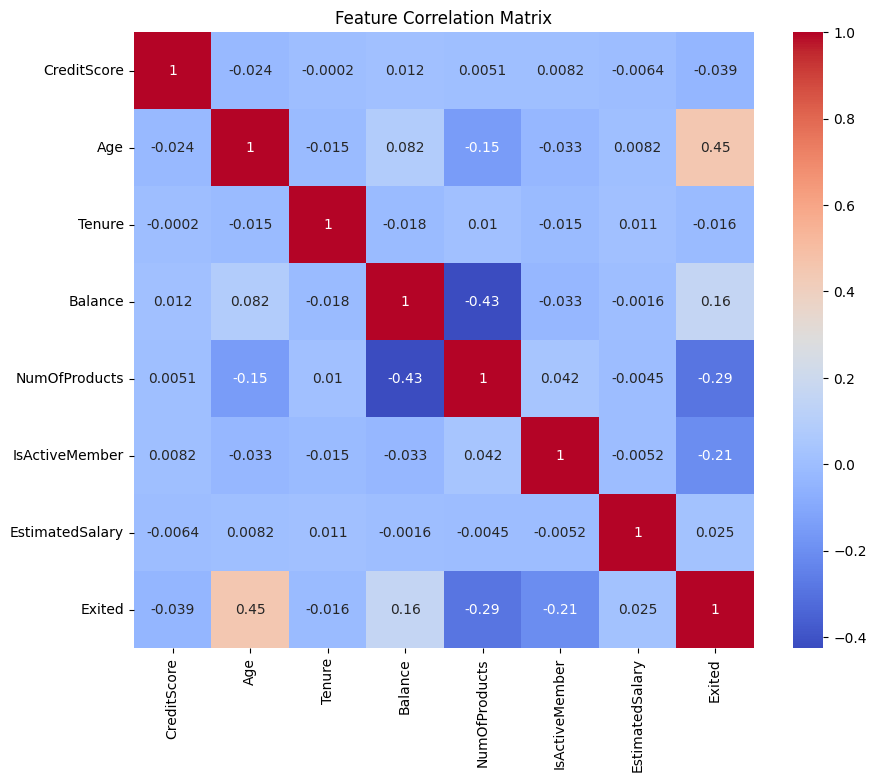

In [ ]:
#find feature importance
import seaborn as sns
import matplotlib.pyplot as plt

X, y, X_test = preprocess_data('train.csv', 'test.csv')

def feature_correlation(X_train, y_train):
    # Combine features and target into a single DataFrame
    data = X_train.copy()
    data['Exited'] = y_train

    # Calculate correlation matrix
    corr_matrix = data.corr()

    # Display correlation with target (Exited)
    target_corr = corr_matrix['Exited'].sort_values(ascending=False)
    print("Correlation with 'Exited':\n", target_corr)

    # Visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.show()

# Call the function to check feature correlations
feature_correlation(X, y)





Feature importance rankings:
Age: 0.3250
NumOfProducts: 0.1678
EstimatedSalary: 0.1528
CreditScore: 0.1390
Balance: 0.1004
Tenure: 0.0692
IsActiveMember: 0.0457


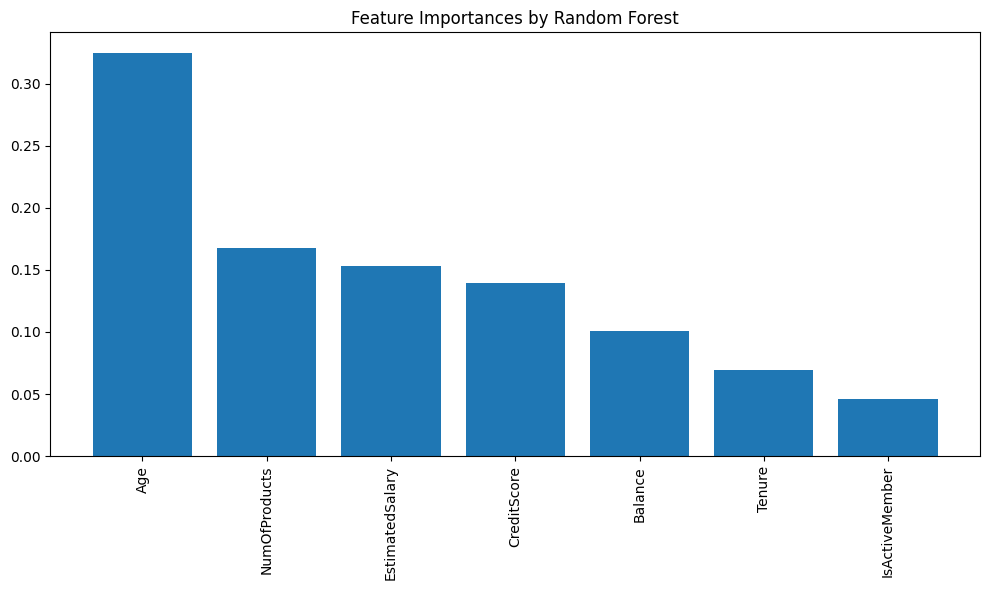

In [ ]:
from sklearn.ensemble import RandomForestClassifier


def random_forest_feature_importance(X_train, y_train):
    # Train a Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Get feature importances from the trained model
    feature_importances = rf_model.feature_importances_

    # Sort features by importance
    indices = np.argsort(feature_importances)[::-1]

    # Print the feature importance rankings
    print("Feature importance rankings:")
    for i in range(X_train.shape[1]):
        print(f"{X_train.columns[indices[i]]}: {feature_importances[indices[i]]:.4f}")

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances by Random Forest")
    plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Call the function to check feature importances
random_forest_feature_importance(X, y)

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np

def cross_validate(X, y, knn, n_splits=5):
    """
    Perform K-Fold cross-validation and compute AUC-ROC scores for each fold.
    """
    X = np.array(X)
    y = np.array(y)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in kf.split(X):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the KNN model
        knn.fit(X_train, y_train)

        # Predict probabilities
        y_prob = knn.predict(X_val)

        # Calculate AUC-ROC score
        auc_score = roc_auc_score(y_val, y_prob)
        auc_scores.append(auc_score)

    return auc_scores



In [ ]:
# Load and preprocess data
from sklearn.model_selection import train_test_split
X, y, X_test = preprocess_data('train.csv', 'test.csv')
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.7, random_state=42)
# Create and evaluate model
knn = KNN(k=19, distance_metric='euclidean')

# Perform cross-validation
cv_scores = cross_validate(X_small, y_small, knn)

print("Cross-validation scores:", cv_scores)

Cross-validation scores: [0.8666666666666667, 0.8766666666666667, 0.87, 0.8888888888888888, 0.8855555555555555]


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def find_best_k(X, y, k_values, n_splits=5):
    """
    Find the best k value by performing cross-validation for each k.

    Parameters:
    - X: Training features
    - y: Training labels
    - k_values: List of k values to test
    - n_splits: Number of cross-validation folds (default is 5)

    Returns:
    - best_k: The value of k with the highest cross-validation accuracy
    - best_score: The highest average cross-validation score
    - all_scores: A dictionary containing k values and their corresponding scores
    """

    all_scores = {}
    best_k = None
    best_score = -1

    for k in k_values:
        # Initialize the KNN model for the current k
        knn = KNN(k=k,distance_metric='euclidean')

        # Perform cross-validation
        scores = cross_validate(X_small,y_small,knn)

        # Compute the mean accuracy for the current k
        mean_score = np.mean(scores)

        # Store the results
        all_scores[k] = mean_score

        # Update the best k if the current score is better
        if mean_score > best_score:
            best_k = k
            best_score = mean_score

        print(f"k = {k}, Cross-validation accuracy: {mean_score:.4f}")

    return best_k, best_score, all_scores

# Define the range of k values to test
k_values = [15,17,19,21]

# Find the best k
X, y, X_test = preprocess_data('train.csv', 'test.csv')
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.7, random_state=42)
best_k, best_score, all_scores = find_best_k(X_small, y_small, k_values)

print(f"Best k: {best_k} with accuracy: {best_score:.4f}")

k = 15, Cross-validation accuracy: 0.8733
k = 17, Cross-validation accuracy: 0.8760
k = 19, Cross-validation accuracy: 0.8776
k = 21, Cross-validation accuracy: 0.8773
Best k: 19 with accuracy: 0.8776


In [ ]:
k = 3, Cross-validation accuracy: 0.8500
k = 5, Cross-validation accuracy: 0.8596
k = 7, Cross-validation accuracy: 0.8656
k = 9, Cross-validation accuracy: 0.8664
k = 11, Cross-validation accuracy: 0.8658
k = 13, Cross-validation accuracy: 0.8687
k = 15, Cross-validation accuracy: 0.8733
k = 17, Cross-validation accuracy: 0.8760
k = 19, Cross-validation accuracy: 0.8776
k = 21, Cross-validation accuracy: 0.8773
Best k: 19 with accuracy: 0.8776

In [19]:
# Load and preprocess data
X1, y1, X_test1 = preprocess_data('train.csv', 'test.csv')

# Create and evaluate model
knn1 = KNN(k=19, distance_metric='euclidean')

# Perform cross-validation
cv_scores1 = cross_validate(X1, y1, knn1)

print("Cross-validation scores:", cv_scores1)

# TODO: hyperparamters tuning


# TODO: Train on full dataset with optimal hyperparameters and make predictions on test set

knn1.fit(X1, y1)

test_predictions = predict_in_batches(knn1, X_test1, batch_size=1000)

# Save test predictions
pd.DataFrame({'id': pd.read_csv('test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)

Cross-validation scores: [0.8983023141534463, 0.9008972621306587, 0.899127959306665, 0.9033766877245138, 0.9173658045417443]
